In [2]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread
from glob import glob
import cv2

from skimage.color import rgb2gray
from skimage.filters import rank

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
! pwd

/Users/niloufar/Desktop/Brain_Tumor_Project/notebooks


Reading and Cleaning (Add labels from masks)

In [4]:
#file_path='/'
#
# outside of collab
from pathlib import Path
file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

mask_files = glob(file_path + os.path.join('all_images','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

In [5]:
print(file_path)

/Users/niloufar/Downloads/


In [6]:
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [7]:
df.shape

(3929, 3)

In [8]:
print(df.columns)
df.head()

Index(['image', 'mask', 'label'], dtype='object')


,image,mask,label
0,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,0
1,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,0
2,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,0
3,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,0
4,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,/Users/niloufar/Downloads/all_images/TCGA_CS_6...,0


Image Exploratory Analysis and Checking classes

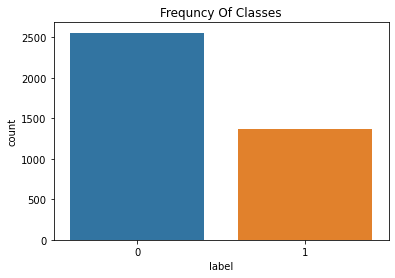

In [9]:
sns.countplot(data=df,x=df['label'])
plt.title('Frequncy Of Classes')
plt.show()

In [10]:
List_of_images= [ plt.imread(path) for path in df["image"]  ]
List_gray_images = [rgb2gray(rgb_img) for rgb_img in List_of_images]

List_of_images = np.array(List_of_images)
List_gray_images = np.array(List_gray_images)

In [11]:
List_gray_images.shape

(3929, 256, 256)

Confirming the Size of all Images

Text(0.5, 1.0, 'Histogram of image height')

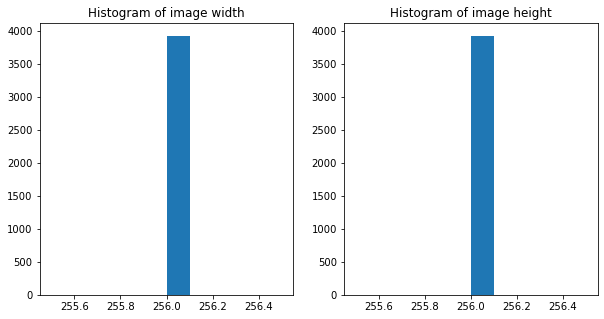

In [12]:
IMAGE_WIDTH = []
IMAGE_HEIGHT = []

for path in df['image']:
  IMAGE_WIDTH.append(imread(path).shape[0])
  IMAGE_HEIGHT.append(imread(path).shape[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
width_hist = axes[0].hist(IMAGE_WIDTH)
height_hist = axes[1].hist(IMAGE_HEIGHT)
axes[0].set_title("Histogram of image width")
axes[1].set_title("Histogram of image height")

In [13]:
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk, ball

def show_image_and_mask(img_path, mask_path):
    rgb_img = imread(img_path)
    gray_img = rgb2gray(rgb_img)
    #filtered_img = filters.farid(gray_img)
    #filtered_img = filters.rank.equalize(gray_img,disk(20))
    filtered_img = filters.rank.enhance_contrast(gray_img,disk(5))
    mask_img = imread(mask_path)
    

    fig, axes = plt.subplots(1, 4, figsize=(10, 8))
    ax = axes.ravel()
    ax[0].imshow(rgb_img)
    ax[0].set_title("RGB image")
    ax[1].imshow(gray_img, cmap=plt.cm.gray)
    ax[1].set_title("Grayscale")
    ax[2].imshow(filtered_img,cmap=plt.cm.gray )
    ax[2].set_title("Filtered Image")
    ax[3].imshow(mask_img)
    ax[3].set_title("Mask")
    fig.tight_layout()

<ipython-input-14-4a03c2238122>:4: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  show_image_and_mask(test_img, test_img_mask)


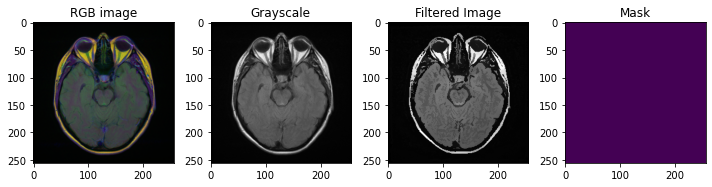

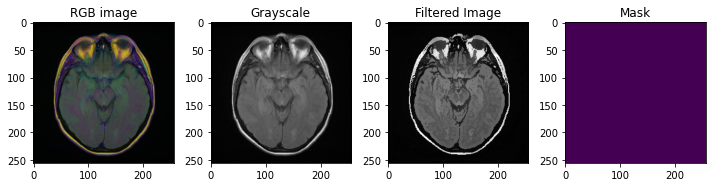

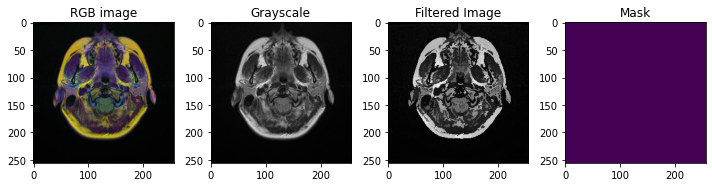

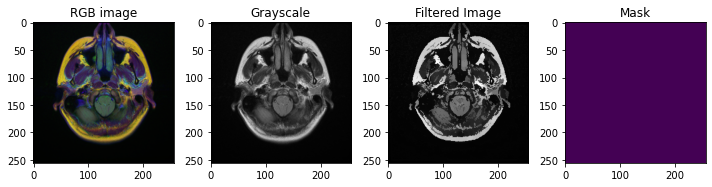

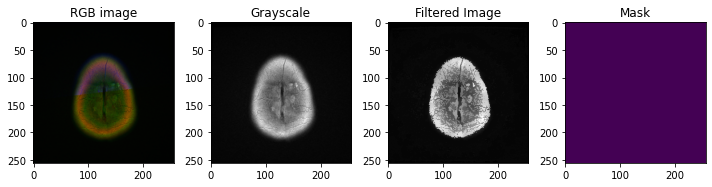

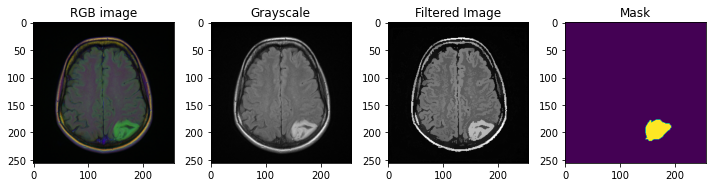

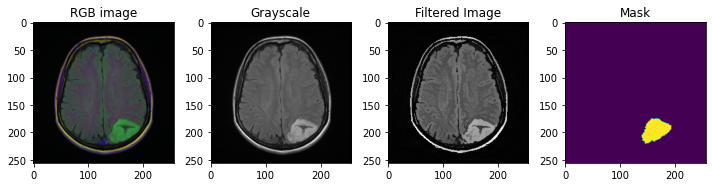

In [14]:
for idx in range(7):
    test_img = df.iloc[idx, 0]
    test_img_mask = df.iloc[idx, 1]
    show_image_and_mask(test_img, test_img_mask)

Text(0.5, 1.0, 'Histogram of pixels in gray images')

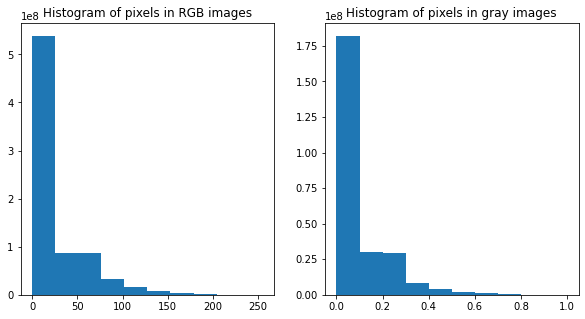

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
rgb_pixel_hist = axes[0].hist(List_of_images.reshape(-1))
gray_pixel_hist = axes[1].hist(List_gray_images.reshape(-1))
axes[0].set_title("Histogram of pixels in RGB images")
axes[1].set_title("Histogram of pixels in gray images")

Histogram of all pixels

## **Part1 - Classification using all features**

## 1-1 Naeive Bayes

### Preparing Train and Test Images

In [69]:
image_dataset = []

for path in df["image"]:
  gray_im = rgb2gray(imread(path))
  #rgb_im = imread(path)
  #image_dataset.append(rgb_im.reshape(-1))
  image_dataset.append(gray_im.reshape(-1))

image_dataset_np = np.array(image_dataset)

image_df = pd.DataFrame(image_dataset_np)

X = image_df
y = df.label
#y=np.array(df["label"].values).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train = X_train/255.0
#X_test = X_test/255.0 
print(X_train.shape)
print(X_test.shape)

(2632, 65536)
(1297, 65536)


In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB()
gnb.fit(X_train, y_train)

ytrain_pred = gnb.predict(X_train)
ytest_pred = gnb.predict(X_test)
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred))
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred))

Train Accuracy =  0.7374620060790273
Test Accuracy =  0.7432536622976099
Train Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.78      1704
           1       0.59      0.80      0.68       928

    accuracy                           0.74      2632
   macro avg       0.73      0.75      0.73      2632
weighted avg       0.77      0.74      0.74      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.78       852
           1       0.59      0.81      0.68       445

    accuracy                           0.74      1297
   macro avg       0.73      0.76      0.73      1297
weighted avg       0.78      0.74      0.75      1297



## 1-2 Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(random_state=0, max_iter=1000, C=1.0)

lgr.fit(X_train, y_train)

ytrain_pred = lgr.predict(X_train)
ytest_pred = lgr.predict(X_test)
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred))
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred))


Train Accuracy =  0.9984802431610942
Test Accuracy =  0.8481110254433307
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1704
           1       1.00      1.00      1.00       928

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       852
           1       0.79      0.76      0.77       445

    accuracy                           0.85      1297
   macro avg       0.83      0.83      0.83      1297
weighted avg       0.85      0.85      0.85      1297



## 1-3 Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

RFC = RandomForestClassifier(n_estimators=300 ,random_state=0)
RFC.fit(X_train, y_train)

ytrain_pred = RFC.predict(X_train)
ytest_pred = RFC.predict(X_test)

print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred))
print ("Train Classification Report:\n",metrics.classification_report(y_train,ytrain_pred))
print ("Test Classification Report:\n",metrics.classification_report(y_test,ytest_pred))

Train Accuracy =  1.0
Test Accuracy =  0.866615265998458
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1704
           1       1.00      1.00      1.00       928

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       852
           1       0.85      0.75      0.79       445

    accuracy                           0.87      1297
   macro avg       0.86      0.84      0.85      1297
weighted avg       0.87      0.87      0.86      1297



## **2- Dimension Reduction and Feature Selection**
## 2-1 Selecting important features form PCA

In [18]:
image_dataset = []

for path in df["image"]:
  gray_im = rgb2gray(imread(path))
  image_dataset.append(gray_im.reshape(-1))

image_dataset_np = np.array(image_dataset)
print(image_dataset_np.shape)

image_df = pd.DataFrame(image_dataset_np)
print(image_df.shape)

(3929, 65536)
(3929, 65536)


In [19]:
from sklearn  import decomposition 
pca_model = decomposition.PCA() #if you dont specify n_componenets it will be min(n_sample,n_features)
pca_model.fit(image_df)

PCA()

In [20]:
pca_projection = pca_model.transform(image_df) # this is scores
pca_projection.shape

(3929, 3929)

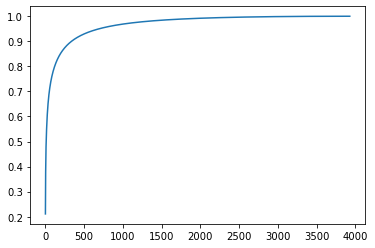

In [21]:
explianed_var=pca_model.explained_variance_ratio_
plt.plot(np.arange(len(explianed_var)),explianed_var.cumsum())

In [22]:
type(pca_projection)

numpy.ndarray

In [23]:
eigenvectors = pca_model.components_  
#each row in eigenvectors is one component which is a linear combination of all features

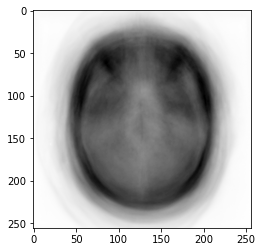

In [24]:
pc1= eigenvectors[0,:].reshape(256,256)
plt.imshow(pc1,cmap='gray_r') 

### **PC-reconstructed image using less features (90%)**

In [25]:
pca_model2 = decomposition.PCA(n_components=0.9)
pca_model2.fit(image_df)
pca_projection2 = pca_model2.transform(image_df) #this is scores
pca_projection2.shape


(3929, 338)

In [27]:
pca_recovered = pca_model2.inverse_transform(pca_projection2)
pca_recovered.shape

(3929, 65536)

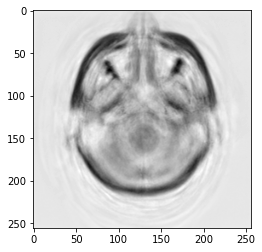

In [28]:
recovered_image1= pca_recovered[3,:].reshape(256,256)
plt.imshow(-recovered_image1,cmap='gray')  #or plt.imshow(recovered_image1,cmap='gray_r') 

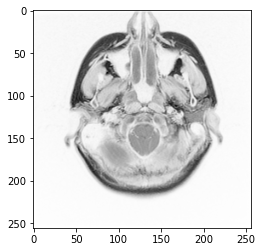

In [29]:
image1 = image_dataset_np[3,:].reshape(256,256)
image1.shape
plt.imshow(image1,cmap='gray_r') 

In [31]:
pca_projection2.shape
type(pca_projection2)

numpy.ndarray

In [73]:
PCA_features = pca_projection2
PCA_features.shape

(3929, 338)

## 2-2 Random forest feature importance

In [33]:
feature_names=np.arange(65536)
importances = RFC.feature_importances_


import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

In [50]:
RF_features = forest_importances.sort_values(ascending=False)[:1000].index
RF_features.shape

(1000,)

## **Part3 - Classification using reduced features**

## 3-1 Using important features from random forest

In [113]:
X_train_reduced = X_train.iloc[:,RF_features]
X_test_reduced = X_test.iloc[:,RF_features]

y_train = np.array(y_train.values).astype(int)
y_test = np.array(y_test.values).astype(int)

In [114]:
RFC_reduced = RandomForestClassifier(n_estimators=300 ,random_state=0)
RFC_reduced.fit(X_train_reduced, y_train)

ytrain_pred_reduced = RFC_reduced.predict(X_train_reduced)
ytest_pred_reduced = RFC_reduced.predict(X_test_reduced)

print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n",metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n",metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  1.0
Test Accuracy =  0.8442559753276793
AUC Score =  0.8186566967347153
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1704
           1       1.00      1.00      1.00       928

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       852
           1       0.79      0.74      0.76       445

    accuracy                           0.84      1297
   macro avg       0.83      0.82      0.82      1297
weighted avg       0.84      0.84      0.84      1297



In [115]:

lgr_reduced = LogisticRegression(random_state=0, max_iter=1000, C=1.0)

lgr_reduced.fit(X_train_reduced, y_train)

ytrain_pred_reduced = lgr_reduced.predict(X_train_reduced)
ytest_pred_reduced = lgr_reduced.predict(X_test_reduced)


In [116]:
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  0.8586626139817629
Test Accuracy =  0.8033924441017734
AUC Score =  0.7714511789840165
Train Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1704
           1       0.82      0.77      0.79       928

    accuracy                           0.86      2632
   macro avg       0.85      0.84      0.84      2632
weighted avg       0.86      0.86      0.86      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       852
           1       0.73      0.67      0.70       445

    accuracy                           0.80      1297
   macro avg       0.78      0.77      0.78      1297
weighted avg       0.80      0.80      0.80      1297



In [117]:
gnb_reduced = GaussianNB()
gnb_reduced.fit(X_train_reduced, y_train)

ytrain_pred_reduced = gnb_reduced.predict(X_train_reduced)
ytest_pred_reduced = gnb_reduced.predict(X_test_reduced)

In [119]:
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  0.7473404255319149
Test Accuracy =  0.7409406322282189
AUC Score =  0.7443121274463259
Train Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      1704
           1       0.61      0.79      0.69       928

    accuracy                           0.75      2632
   macro avg       0.74      0.76      0.74      2632
weighted avg       0.77      0.75      0.75      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79       852
           1       0.60      0.76      0.67       445

    accuracy                           0.74      1297
   macro avg       0.72      0.74      0.73      1297
weighted avg       0.76      0.74      0.75      1297



In [177]:
from sklearn.svm import SVC
from sklearn import metrics

svm_rbf_reduced = SVC(kernel='rbf',random_state=0)
svm_rbf_reduced.fit(X_train_reduced,y_train)

ytrain_pred_reduced = svm_rbf_reduced.predict(X_train_reduced)
ytest_pred_reduced = svm_rbf_reduced.predict(X_test_reduced)

In [178]:
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  0.9099544072948328
Test Accuracy =  0.8535080956052429
AUC Score =  0.8305296196655589
Train Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1704
           1       0.87      0.88      0.87       928

    accuracy                           0.91      2632
   macro avg       0.90      0.90      0.90      2632
weighted avg       0.91      0.91      0.91      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       852
           1       0.80      0.76      0.78       445

    accuracy                           0.85      1297
   macro avg       0.84      0.83      0.84      1297
weighted avg       0.85      0.85      0.85      1297



In [181]:
from sklearn.svm import SVC
from sklearn import metrics

svm_poly_reduced = SVC(kernel='poly',random_state=0)
svm_poly_reduced.fit(X_train_reduced,y_train)

ytrain_pred_reduced = svm_poly_reduced.predict(X_train_reduced)
ytest_pred_reduced = svm_poly_reduced.predict(X_test_reduced)

In [182]:
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  0.9517477203647416
Test Accuracy =  0.825751734772552
AUC Score =  0.7890066993722634
Train Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1704
           1       0.98      0.88      0.93       928

    accuracy                           0.95      2632
   macro avg       0.96      0.94      0.95      2632
weighted avg       0.95      0.95      0.95      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       852
           1       0.79      0.67      0.73       445

    accuracy                           0.83      1297
   macro avg       0.81      0.79      0.80      1297
weighted avg       0.82      0.83      0.82      1297



In [130]:
from sklearn.neighbors import KNeighborsClassifier
knn_reduced = KNeighborsClassifier(n_neighbors=3)
knn_reduced.fit(X_train_reduced, y_train)

ytrain_pred_reduced = knn_reduced.predict(X_train_reduced)
ytest_pred_reduced = knn_reduced.predict(X_test_reduced)

In [132]:
print ("Train Accuracy = ", metrics.accuracy_score(y_train,ytrain_pred_reduced))
print ("Test Accuracy = ", metrics.accuracy_score(y_test,ytest_pred_reduced))
print("AUC Score = ",metrics.roc_auc_score(y_test,ytest_pred_reduced) )
print ("Train Classification Report:\n", metrics.classification_report(y_train,ytrain_pred_reduced))
print ("Test Classification Report:\n", metrics.classification_report(y_test,ytest_pred_reduced))

Train Accuracy =  0.9308510638297872
Test Accuracy =  0.8334618350038551
AUC Score =  0.8168816268396899
Train Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1704
           1       0.90      0.91      0.90       928

    accuracy                           0.93      2632
   macro avg       0.92      0.93      0.92      2632
weighted avg       0.93      0.93      0.93      2632

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       852
           1       0.75      0.76      0.76       445

    accuracy                           0.83      1297
   macro avg       0.81      0.82      0.82      1297
weighted avg       0.83      0.83      0.83      1297



## 3-2 Using PCA important features

In [75]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(PCA_features, y, test_size=0.33, random_state=42)

print(X_train_pca.shape)
print(X_test_pca.shape)

(2632, 338)
(1297, 338)


In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

names = ["Naive_Bayes","Logistic Regression","Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", 
         "Gradient_Boosting", "Decision_Tree", "Random_Forest", "Quadratic Discriminant Analysis",
          "SGD Classifier"]

classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=0, max_iter=1000, C=1.0),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025,random_state=0),
    SVC(kernel="poly", random_state=0),
    SVC(kernel="rbf", random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=300 ,random_state=0),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [101]:
type(y_train)
Y_train = np.array(y_train.values).astype(int)
Y_train.shape

(2632,)

In [146]:

#from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


classification_scores = []
precision = []
recall = []
Fscore = []
classificaation_auc = []


for name, clf in zip(names, classifiers):
    
    clf.fit(X_train_pca, Y_train)
    y_pred = clf.predict(X_test_pca)
    score = clf.score(X_test_pca, y_test)
    prec = precision_score(y_test, y_pred, average='micro')
    rec = recall_score(y_test, y_pred, average='micro')
    fs= f1_score(y_test, y_pred, average='micro')
    auc = roc_auc_score(y_test,y_pred, average = 'macro')
    classification_scores.append(score)
    precision.append(prec)
    recall.append(rec)
    Fscore.append(fs)
    classificaation_auc.append(auc)

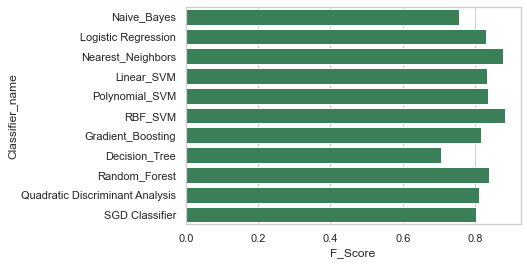

In [174]:
df = pd.DataFrame()
df['Classifier_name'] = names
df['Accuracy'] = classification_scores
df['Precision'] = precision
df['Recall'] = recall
df['F_Score'] = Fscore
df['AUC'] = classificaation_auc


colors = sns.color_palette("rocket_r", as_cmap=True)
color_df = df.style.background_gradient(cmap=colors)

ax = sns.barplot(y="Classifier_name", x="F_Score", data=df, color='seagreen')

In [171]:
df.head(11)

,Classifier_name,Accuracy,Precision,Recall,F_Score,AUC
0,Naive_Bayes,0.754819,0.754819,0.754819,0.754819,0.752729
1,Logistic Regression,0.829607,0.829607,0.829607,0.829607,0.809653
2,Nearest_Neighbors,0.877409,0.877409,0.877409,0.877409,0.865361
3,Linear_SVM,0.832691,0.832691,0.832691,0.832691,0.811464
4,Polynomial_SVM,0.836546,0.836546,0.836546,0.836546,0.777363
5,RBF_SVM,0.881264,0.881264,0.881264,0.881264,0.862928
6,Gradient_Boosting,0.815729,0.815729,0.815729,0.815729,0.785135
7,Decision_Tree,0.704703,0.704703,0.704703,0.704703,0.718340
8,Random_Forest,0.838859,0.838859,0.838859,0.838859,0.775903
9,Quadratic Discriminant Analysis,0.811103,0.811103,0.811103,0.811103,0.819722


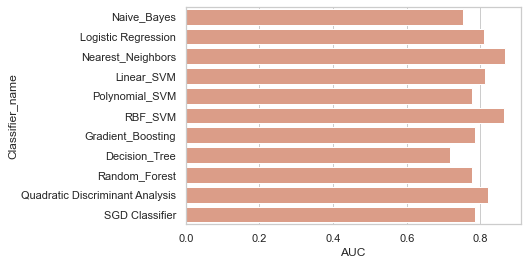

In [173]:
ax = sns.barplot(y="Classifier_name", x="AUC", data=df, color='darksalmon')
#ax.bar_label(ax.containers[0])

## 3-3 Evaluation (continued)

In [183]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import randint

import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


def plot_roc_curve(models):
  auc_list = []

  plt.figure(figsize=(12, 8))
  plt.plot([0, 1], [0, 1], 'y--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')

  for idx, (name, model,X_test) in enumerate(models):
    y_preds = model.predict(X_test).ravel().astype(int)
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    auc_value = auc(fpr, tpr)
    auc_list.append(auc_value)
    label = str(name) + " - AUC: " + str(round(auc_value, 3))
    plt.plot(fpr, tpr, marker='.', color=colors_list[randint(len(colors_list) - 1)], label=label)

  plt.legend()
  
  return auc_list

In [185]:
models = [("Logistic Regression", lgr_reduced,X_test_reduced), ("Gaussian Naive Bayes", gnb_reduced,X_test_reduced),
    ("Random Forest", RFC_reduced,X_test_reduced), ("KNN",knn_reduced, X_test_reduced),
("SVM-RBF", svm_rbf_reduced,X_test_reduced), ("SVM-Ploy", svm_poly_reduced, X_test_reduced)]